# Chart Infomation Extractor Experiment
- Chart의 맥락수준을 기준으로 저,고 맥락 이미지로 구분하여 정보 추출 실험
- 맥락 수준이란, key information, key insights의 포함 정보를 의미
- key information, key insights는 context와 관련있지만 직접적으로 언급되지 않은 정보를 의미
- 또한 gpt-4o 모델과 gpt-4o-mini 모델을 비교함

# 프롬프트 구분
- chart 분석 과정 유무를 기준으로 비교

### 결론
- 



In [3]:
import os
import json
import yaml
from pprint import pprint

from IPython.display import Image, display

from typing import TypedDict, Annotated, List, Dict, Tuple

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import load_prompt

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
with open('../data/document/역도/documentParseGraph_state.json', 'r') as f:
    state = json.load(f)

class GraphState(TypedDict):
    filepath: Annotated[str, 'filepath']
    filepath_pdf: Annotated[str, 'pdf filepath']
    originData: Annotated[List[Dict], 'originData']
    documents: Annotated[List[Dict], 'documents']
    heading_structure: Annotated[List[str], 'heading structure. last heading is borderline']
    unused_elements: Annotated[List[Tuple[str, str]], 'unused elements']
    image_result: Annotated[List[Dict], 'result of image information extractor ']
    chart_result: Annotated[List[Dict], 'result of chart information extractor ']
    table_result: Annotated[List[Dict], 'result of table information extractor ']
    
state = GraphState(**state)

In [5]:
state

{'filepath': '../data/document/역도/역도 훈련프로그램 구성 및 지도안_edited.json',
 'filepath_pdf': '../data/document/역도/역도 훈련프로그램 구성 및 지도안.pdf',
 'originData': [{'category': 'heading1',
   'coordinates': [{'x': 0.2295, 'y': 0.0994},
    {'x': 0.7689, 'y': 0.0994},
    {'x': 0.7689, 'y': 0.128},
    {'x': 0.2295, 'y': 0.128}],
   'id': 0,
   'page': 1,
   'relatedID': [],
   'class': 'heading1',
   'text': 'Ⅴ.역도 훈련프로그램 구성 및 지도안'},
  {'category': 'heading1',
   'coordinates': [{'x': 0.1225, 'y': 0.2216},
    {'x': 0.4524, 'y': 0.2216},
    {'x': 0.4524, 'y': 0.2453},
    {'x': 0.1225, 'y': 0.2453}],
   'id': 1,
   'page': 1,
   'relatedID': [],
   'class': 'heading2',
   'text': '1. 훈련프로그램의 구성 원리'},
  {'category': 'paragraph',
   'coordinates': [{'x': 0.123, 'y': 0.2572},
    {'x': 0.8773, 'y': 0.2572},
    {'x': 0.8773, 'y': 0.3385},
    {'x': 0.123, 'y': 0.3385}],
   'id': 2,
   'page': 1,
   'relatedID': [],
   'class': 'default',
   'text': '역도 훈련프로그램의 구성은 트레이닝의 원리에 입각하여 안전하고 효과적인 훈\n련 프로그램을 설계하여 선

## Image to base64

In [6]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image_content = image_file.read()
        file_ext = os.path.splitext(image_path)[1].lower()

        if file_ext in ['.jpg', '.jpeg']:
            mime_type = 'image/jpeg'
        elif file_ext == '.png':
            mime_type = 'image/png'
        else:
            mime_type = 'image/unknown'

        return base64.b64encode(image_content).decode("utf-8"), mime_type


In [7]:
def load_prompt(yaml_file):
    with open(yaml_file, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

In [14]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

class ChartInfomationExtract(BaseModel):
    detail: str = Field(description='key insights and information visible in the Chart')
    entity: List[str] = Field(description="significant entities or objects in Chart")
    hypotheticalQuestions: List[str] = Field(description="relevant hypothetical questions")    

parser = PydanticOutputParser(pydantic_object=ChartInfomationExtract)

In [15]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"detail": {"description": "key insights and information visible in the Chart", "title": "Detail", "type": "string"}, "entity": {"description": "significant entities or objects in Chart", "items": {"type": "string"}, "title": "Entity", "type": "array"}, "hypotheticalQuestions": {"description": "relevant hypothetical questions", "items": {"type": "string"}, "title": "Hypotheticalquestions", "type": "array"}}, "required": ["detail", "entity", "hypotheticalQuestions"]}\n```'

In [16]:
llm_gpt4o = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_gpt4o_mini = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [12]:
def draw_image_result(image_path, chain, context, title, parser):
    base64, mime_type = encode_image(image_path)
    result = chain.invoke({'base64_image': base64, 
                           'image_type': mime_type,
                           'context': context, 
                           'title': title,
                           'language': 'KOREAN'})

    display(Image(image_path))
    print(f"title: {title}")
    print(f"context: {context}")
    print("\n\n--------------------------------\n\n")

    result_parse = parser.parse(result.content)

    print(f"detail: {result_parse.detail}")
    print(f"entity: {result_parse.entity}")
    print(f"hypotheticalQuestions: {result_parse.hypotheticalQuestions}")
    print("\n\n--------------------------------\n\n")

    input_token = result.response_metadata['token_usage']['prompt_tokens']
    output_token = result.response_metadata['token_usage']['completion_tokens']

    input_dolor = round(input_token * 0.0001 * 0.15, 5)
    output_dolor = round(output_token * 0.0001 * 
    0.6, 5)

    input_won = round(input_dolor * 1440)
    output_won = round(output_dolor * 1440)

    print(f"input: {input_token},  {input_dolor}$, {input_won}원")
    print(f"output: {output_token},  {output_dolor}$, {output_won}원")
    return result

In [19]:
summary_high_1 = "장미란 선수는 3,4국면에서 좌측 하지근을 우측보다 더 많이 활용합니다. 측정 결과 양쪽 무릎 신전근의 힘은 비슷하므로, 이는 근력 약화 문제가 아닌 그녀만의 동작 특성(오른발을 빠르고 짧게 누름)에서 기인합니다. 개선을 위해 오른발의 풀 동작 시 길고 강하게 수행하는 훈련이 필요하며, 3국면에서는 복직근과 광배근을 더 활용하는 동작으로 변화가 요구됩니다. 또한 3,4국면에서 오른발이 후방으로 빠지는 동작으로 인한 좌측 승모근 상해 위험에 주의해야 합니다."
summary_low_1 = "주간 총부하량은 시합기, 훈련기, 이완기에 따라 달리 설정해야 하며, 특히 시합 4주 전부터는 월간 총부하량 내에서 계획적으로 분배해야 합니다. 부하량 감소 시 15-18% 이상 줄이면 기록 유지와 향상에 부정적 영향을 미치므로 주의가 필요합니다. 우수선수의 경우 주간 부하량을 첫날 54%, 둘째날 30%, 셋째날 16%로 분배하는 경향이 있으나, 개인 상황에 맞게 조정해야 하며 초보자에게는 다른 접근이 필요합니다. 무엇보다 큰 부하 후에는 작은 부하를 통해 신체의 회복을 도모하는 것이 중요합니다."

high_1_title = "그림 26. 장미란 선수의 인상동작 수행 시 근육활동에 대한 분석"
low_1_title = "그림 134. 주간 훈련 부하량"


high_1_chart_path = '../data/experiment/informationExtract/chart/high_1.png'
low_1_chart_path = '../data/experiment/informationExtract/chart/low_1.png'

## chart 분석 무 프롬프트 (chart_20250304_01)

In [17]:
prompt = load_prompt('../prompt/information_chart/chart_20250227_01.yaml')
chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
chat_prompt = chat_prompt.partial(format=parser.get_format_instructions())

chart_gpt4o_chain = chat_prompt | llm_gpt4o
chart_gpt4o_mini_chain = chat_prompt | llm_gpt4o_mini

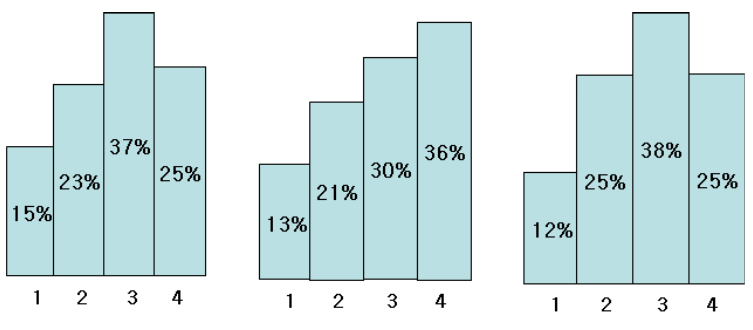

title: 그림 134. 주간 훈련 부하량
context: 주간 총부하량은 시합기, 훈련기, 이완기에 따라 달리 설정해야 하며, 특히 시합 4주 전부터는 월간 총부하량 내에서 계획적으로 분배해야 합니다. 부하량 감소 시 15-18% 이상 줄이면 기록 유지와 향상에 부정적 영향을 미치므로 주의가 필요합니다. 우수선수의 경우 주간 부하량을 첫날 54%, 둘째날 30%, 셋째날 16%로 분배하는 경향이 있으나, 개인 상황에 맞게 조정해야 하며 초보자에게는 다른 접근이 필요합니다. 무엇보다 큰 부하 후에는 작은 부하를 통해 신체의 회복을 도모하는 것이 중요합니다.


--------------------------------


detail: 주간 훈련 부하량은 세 가지 다른 패턴으로 나타나며, 각 패턴의 부하량 비율은 다음과 같습니다: 첫 번째 패턴은 1주차 15%, 2주차 23%, 3주차 37%, 4주차 25%; 두 번째 패턴은 1주차 13%, 2주차 21%, 3주차 30%, 4주차 36%; 세 번째 패턴은 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%이다. 각 패턴은 주간 훈련 부하량의 분배를 보여준다.
entity: ['주간 훈련 부하량', '첫 번째 패턴', '두 번째 패턴', '세 번째 패턴']
hypotheticalQuestions: ['각 패턴의 부하량 분배가 선수의 성과에 미치는 영향은 무엇인가?', '부하량 감소가 기록 유지에 미치는 부정적 영향은 어떤 방식으로 나타나는가?', '초보자에게 적합한 훈련 부하량 분배는 어떻게 설정해야 하는가?', '훈련 부하량을 조정할 때 고려해야 할 개인적 요소는 무엇인가?']


--------------------------------


input: 1309,  0.01964$, 28원
output: 308,  0.01848$, 27원


AIMessage(content='```json\n{\n  "detail": "주간 훈련 부하량은 세 가지 다른 패턴으로 나타나며, 각 패턴의 부하량 비율은 다음과 같습니다: 첫 번째 패턴은 1주차 15%, 2주차 23%, 3주차 37%, 4주차 25%; 두 번째 패턴은 1주차 13%, 2주차 21%, 3주차 30%, 4주차 36%; 세 번째 패턴은 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%이다. 각 패턴은 주간 훈련 부하량의 분배를 보여준다.",\n  "entity": [\n    "주간 훈련 부하량",\n    "첫 번째 패턴",\n    "두 번째 패턴",\n    "세 번째 패턴"\n  ],\n  "hypotheticalQuestions": [\n    "각 패턴의 부하량 분배가 선수의 성과에 미치는 영향은 무엇인가?",\n    "부하량 감소가 기록 유지에 미치는 부정적 영향은 어떤 방식으로 나타나는가?",\n    "초보자에게 적합한 훈련 부하량 분배는 어떻게 설정해야 하는가?",\n    "훈련 부하량을 조정할 때 고려해야 할 개인적 요소는 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 308, 'prompt_tokens': 1309, 'total_tokens': 1617, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd6096

In [22]:
draw_image_result(low_1_chart_path, chart_gpt4o_mini_chain, summary_low_1, low_1_title, parser)

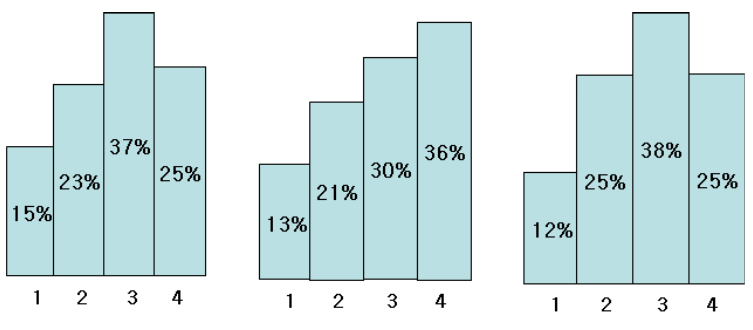

title: 그림 134. 주간 훈련 부하량
context: 주간 총부하량은 시합기, 훈련기, 이완기에 따라 달리 설정해야 하며, 특히 시합 4주 전부터는 월간 총부하량 내에서 계획적으로 분배해야 합니다. 부하량 감소 시 15-18% 이상 줄이면 기록 유지와 향상에 부정적 영향을 미치므로 주의가 필요합니다. 우수선수의 경우 주간 부하량을 첫날 54%, 둘째날 30%, 셋째날 16%로 분배하는 경향이 있으나, 개인 상황에 맞게 조정해야 하며 초보자에게는 다른 접근이 필요합니다. 무엇보다 큰 부하 후에는 작은 부하를 통해 신체의 회복을 도모하는 것이 중요합니다.


--------------------------------


detail: 주간 훈련 부하량은 세 가지 다른 패턴으로 나타나며, 각 패턴의 부하량 비율은 다음과 같습니다: 첫 번째 패턴은 1주차 15%, 2주차 23%, 3주차 37%, 4주차 25%; 두 번째 패턴은 1주차 13%, 2주차 21%, 3주차 30%, 4주차 36%; 세 번째 패턴은 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%이다.
entity: ['주간 훈련 부하량', '첫 번째 패턴', '두 번째 패턴', '세 번째 패턴']
hypotheticalQuestions: ['각 패턴의 부하량 비율이 선수의 성과에 미치는 영향은 무엇인가?', '부하량 감소가 기록 유지에 미치는 부정적 영향은 어떤 방식으로 나타날까?', '초보자와 우수선수의 훈련 부하량 분배 방식의 차이는 무엇인가?', '훈련 후 회복을 위한 최적의 부하량 조정 방법은 무엇인가?']


--------------------------------


input: 1309,  0.01964$, 28원
output: 291,  0.01746$, 25원


AIMessage(content='```json\n{\n  "detail": "주간 훈련 부하량은 세 가지 다른 패턴으로 나타나며, 각 패턴의 부하량 비율은 다음과 같습니다: 첫 번째 패턴은 1주차 15%, 2주차 23%, 3주차 37%, 4주차 25%; 두 번째 패턴은 1주차 13%, 2주차 21%, 3주차 30%, 4주차 36%; 세 번째 패턴은 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%이다.",\n  "entity": [\n    "주간 훈련 부하량",\n    "첫 번째 패턴",\n    "두 번째 패턴",\n    "세 번째 패턴"\n  ],\n  "hypotheticalQuestions": [\n    "각 패턴의 부하량 비율이 선수의 성과에 미치는 영향은 무엇인가?",\n    "부하량 감소가 기록 유지에 미치는 부정적 영향은 어떤 방식으로 나타날까?",\n    "초보자와 우수선수의 훈련 부하량 분배 방식의 차이는 무엇인가?",\n    "훈련 후 회복을 위한 최적의 부하량 조정 방법은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 291, 'prompt_tokens': 1309, 'total_tokens': 1600, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'lo

In [20]:
draw_image_result(low_1_chart_path, chart_gpt4o_chain, summary_low_1, low_1_title, parser)

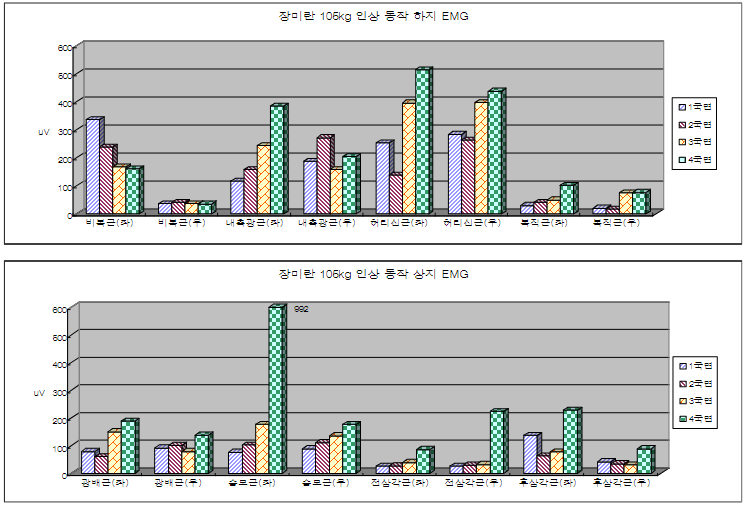

title: 그림 26. 장미란 선수의 인상동작 수행 시 근육활동에 대한 분석
context: 장미란 선수는 3,4국면에서 좌측 하지근을 우측보다 더 많이 활용합니다. 측정 결과 양쪽 무릎 신전근의 힘은 비슷하므로, 이는 근력 약화 문제가 아닌 그녀만의 동작 특성(오른발을 빠르고 짧게 누름)에서 기인합니다. 개선을 위해 오른발의 풀 동작 시 길고 강하게 수행하는 훈련이 필요하며, 3국면에서는 복직근과 광배근을 더 활용하는 동작으로 변화가 요구됩니다. 또한 3,4국면에서 오른발이 후방으로 빠지는 동작으로 인한 좌측 승모근 상해 위험에 주의해야 합니다.


--------------------------------


detail: 장미란 선수의 하체와 상체 근육 활동을 비교한 결과, 하체에서는 비복근과 내측광근의 활동이 두드러지며, 상체에서는 광배근과 복직근의 활동이 강조됨. 특히, 3국면에서 복직근과 광배근의 활용이 필요하며, 3,4국면에서 좌측 승모근의 상해 위험이 존재함.
entity: ['장미란 선수', '비복근', '내측광근', '복직근', '광배근', '좌측 승모근']
hypotheticalQuestions: ['장미란 선수의 동작 특성을 개선하기 위해 어떤 훈련 방법이 가장 효과적일까?', '근육 활동의 차이가 선수의 경기력에 어떤 영향을 미칠까?', '좌측 승모근의 상해 위험을 줄이기 위한 예방 조치는 무엇일까?', '오른발의 동작을 개선하기 위한 구체적인 훈련 계획은 어떻게 구성해야 할까?']


--------------------------------


input: 1308,  0.01962$, 28원
output: 257,  0.01542$, 22원


AIMessage(content='```json\n{\n  "detail": "장미란 선수의 하체와 상체 근육 활동을 비교한 결과, 하체에서는 비복근과 내측광근의 활동이 두드러지며, 상체에서는 광배근과 복직근의 활동이 강조됨. 특히, 3국면에서 복직근과 광배근의 활용이 필요하며, 3,4국면에서 좌측 승모근의 상해 위험이 존재함.",\n  "entity": [\n    "장미란 선수",\n    "비복근",\n    "내측광근",\n    "복직근",\n    "광배근",\n    "좌측 승모근"\n  ],\n  "hypotheticalQuestions": [\n    "장미란 선수의 동작 특성을 개선하기 위해 어떤 훈련 방법이 가장 효과적일까?",\n    "근육 활동의 차이가 선수의 경기력에 어떤 영향을 미칠까?",\n    "좌측 승모근의 상해 위험을 줄이기 위한 예방 조치는 무엇일까?",\n    "오른발의 동작을 개선하기 위한 구체적인 훈련 계획은 어떻게 구성해야 할까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 257, 'prompt_tokens': 1308, 'total_tokens': 1565, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-c1a

In [23]:
draw_image_result(high_1_chart_path, chart_gpt4o_mini_chain, summary_high_1, high_1_title, parser)

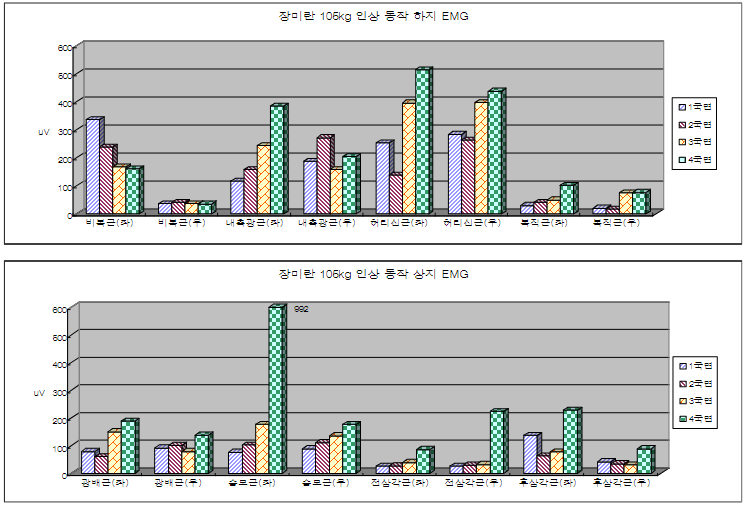

title: 그림 26. 장미란 선수의 인상동작 수행 시 근육활동에 대한 분석
context: 장미란 선수는 3,4국면에서 좌측 하지근을 우측보다 더 많이 활용합니다. 측정 결과 양쪽 무릎 신전근의 힘은 비슷하므로, 이는 근력 약화 문제가 아닌 그녀만의 동작 특성(오른발을 빠르고 짧게 누름)에서 기인합니다. 개선을 위해 오른발의 풀 동작 시 길고 강하게 수행하는 훈련이 필요하며, 3국면에서는 복직근과 광배근을 더 활용하는 동작으로 변화가 요구됩니다. 또한 3,4국면에서 오른발이 후방으로 빠지는 동작으로 인한 좌측 승모근 상해 위험에 주의해야 합니다.


--------------------------------


detail: 장미란 선수의 하체와 상체 근육 활동을 비교한 결과, 하체에서는 비복근과 내측광근의 활동이 두드러지며, 상체에서는 광배근과 복직근의 활동이 강조됨. 특히, 3국면에서 복직근과 광배근의 활용이 필요하며, 3,4국면에서 좌측 승모근의 상해 위험이 존재함.
entity: ['장미란 선수', '비복근', '내측광근', '복직근', '광배근', '좌측 승모근']
hypotheticalQuestions: ['장미란 선수의 동작 특성을 개선하기 위해 어떤 훈련 방법이 가장 효과적일까?', '근육 활동의 차이가 선수의 경기력에 어떤 영향을 미칠까?', '좌측 승모근의 상해 위험을 줄이기 위한 예방 조치는 무엇일까?', '오른발의 동작을 개선하기 위한 구체적인 훈련 계획은 어떻게 구성해야 할까?']


--------------------------------


input: 1308,  0.01962$, 28원
output: 257,  0.01542$, 22원


AIMessage(content='```json\n{\n  "detail": "장미란 선수의 하체와 상체 근육 활동을 비교한 결과, 하체에서는 비복근과 내측광근의 활동이 두드러지며, 상체에서는 광배근과 복직근의 활동이 강조됨. 특히, 3국면에서 복직근과 광배근의 활용이 필요하며, 3,4국면에서 좌측 승모근의 상해 위험이 존재함.",\n  "entity": [\n    "장미란 선수",\n    "비복근",\n    "내측광근",\n    "복직근",\n    "광배근",\n    "좌측 승모근"\n  ],\n  "hypotheticalQuestions": [\n    "장미란 선수의 동작 특성을 개선하기 위해 어떤 훈련 방법이 가장 효과적일까?",\n    "근육 활동의 차이가 선수의 경기력에 어떤 영향을 미칠까?",\n    "좌측 승모근의 상해 위험을 줄이기 위한 예방 조치는 무엇일까?",\n    "오른발의 동작을 개선하기 위한 구체적인 훈련 계획은 어떻게 구성해야 할까?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 257, 'prompt_tokens': 1308, 'total_tokens': 1565, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None}, id='run-d0a237

In [21]:
draw_image_result(high_1_chart_path, chart_gpt4o_chain, summary_high_1, high_1_title, parser)

## chart 분석 무 프롬프트 (chart_20250227_01)



In [24]:
prompt = load_prompt('../prompt/information_chart/chart_20250304_01.yaml')
chat_prompt = ChatPromptTemplate.from_messages(prompt['messages'])
chat_prompt = chat_prompt.partial(format=parser.get_format_instructions())

chart_gpt4o_chain = chat_prompt | llm_gpt4o
chart_gpt4o_mini_chain = chat_prompt | llm_gpt4o_mini

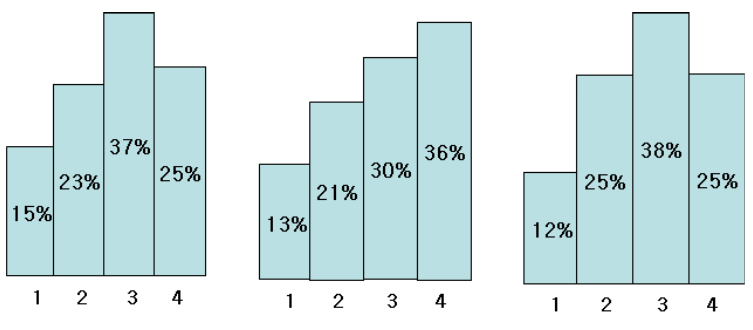

title: 그림 134. 주간 훈련 부하량
context: 주간 총부하량은 시합기, 훈련기, 이완기에 따라 달리 설정해야 하며, 특히 시합 4주 전부터는 월간 총부하량 내에서 계획적으로 분배해야 합니다. 부하량 감소 시 15-18% 이상 줄이면 기록 유지와 향상에 부정적 영향을 미치므로 주의가 필요합니다. 우수선수의 경우 주간 부하량을 첫날 54%, 둘째날 30%, 셋째날 16%로 분배하는 경향이 있으나, 개인 상황에 맞게 조정해야 하며 초보자에게는 다른 접근이 필요합니다. 무엇보다 큰 부하 후에는 작은 부하를 통해 신체의 회복을 도모하는 것이 중요합니다.


--------------------------------


detail: 주간 훈련 부하량은 세 가지 유형(시합기, 훈련기, 이완기)으로 나뉘며, 각 유형에 따라 부하량이 다르게 분배된다. 첫 번째 그래프는 첫날 54%, 둘째날 30%, 셋째날 16%의 비율로 부하량이 분배되는 경향을 보여준다. 두 번째 그래프는 1주차부터 4주차까지의 부하량 비율이 각각 13%, 21%, 30%, 36%로 증가하는 패턴을 나타낸다. 세 번째 그래프는 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%의 비율로 부하량이 조정되는 모습을 보여준다.
entity: ['주간 훈련 부하량', '시합기', '훈련기', '이완기', '첫날', '둘째날', '셋째날', '1주차', '2주차', '3주차', '4주차']
hypotheticalQuestions: ['각 유형별 훈련 부하량의 최적 비율은 어떻게 결정될 수 있을까?', '부하량 감소가 선수의 성과에 미치는 영향은 무엇인가?', '초보자와 우수선수의 훈련 부하량 분배 방식의 차이는 무엇인가?', '훈련 후 회복을 위한 최적의 부하량 조정 방법은 무엇인가?', '부하량 조정이 선수의 심리적 상태에 미치는 영향은 어떤가?']


--------------------------------


input: 1283,  0.01924$, 28원
output: 393, 

AIMessage(content='```json\n{\n  "detail": "주간 훈련 부하량은 세 가지 유형(시합기, 훈련기, 이완기)으로 나뉘며, 각 유형에 따라 부하량이 다르게 분배된다. 첫 번째 그래프는 첫날 54%, 둘째날 30%, 셋째날 16%의 비율로 부하량이 분배되는 경향을 보여준다. 두 번째 그래프는 1주차부터 4주차까지의 부하량 비율이 각각 13%, 21%, 30%, 36%로 증가하는 패턴을 나타낸다. 세 번째 그래프는 1주차 12%, 2주차 25%, 3주차 38%, 4주차 25%의 비율로 부하량이 조정되는 모습을 보여준다.",\n  "entity": [\n    "주간 훈련 부하량",\n    "시합기",\n    "훈련기",\n    "이완기",\n    "첫날",\n    "둘째날",\n    "셋째날",\n    "1주차",\n    "2주차",\n    "3주차",\n    "4주차"\n  ],\n  "hypotheticalQuestions": [\n    "각 유형별 훈련 부하량의 최적 비율은 어떻게 결정될 수 있을까?",\n    "부하량 감소가 선수의 성과에 미치는 영향은 무엇인가?",\n    "초보자와 우수선수의 훈련 부하량 분배 방식의 차이는 무엇인가?",\n    "훈련 후 회복을 위한 최적의 부하량 조정 방법은 무엇인가?",\n    "부하량 조정이 선수의 심리적 상태에 미치는 영향은 어떤가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 393, 'prompt_tokens': 1283, 'total_tokens': 1676, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 

In [25]:
draw_image_result(low_1_chart_path, chart_gpt4o_mini_chain, summary_low_1, low_1_title, parser)

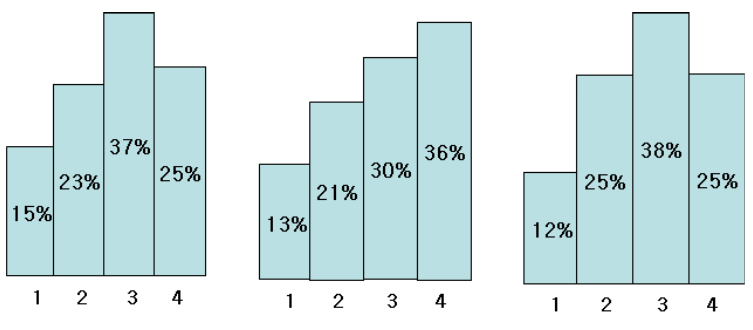

title: 그림 134. 주간 훈련 부하량
context: 주간 총부하량은 시합기, 훈련기, 이완기에 따라 달리 설정해야 하며, 특히 시합 4주 전부터는 월간 총부하량 내에서 계획적으로 분배해야 합니다. 부하량 감소 시 15-18% 이상 줄이면 기록 유지와 향상에 부정적 영향을 미치므로 주의가 필요합니다. 우수선수의 경우 주간 부하량을 첫날 54%, 둘째날 30%, 셋째날 16%로 분배하는 경향이 있으나, 개인 상황에 맞게 조정해야 하며 초보자에게는 다른 접근이 필요합니다. 무엇보다 큰 부하 후에는 작은 부하를 통해 신체의 회복을 도모하는 것이 중요합니다.


--------------------------------


detail: 주간 훈련 부하량은 세 가지 유형으로 나뉘며, 각 주차별로 부하량이 다르게 분배되어 있다. 첫 번째 그래프는 첫날 54%, 둘째날 30%, 셋째날 16%의 비율로 부하량이 분배된 것을 보여준다. 두 번째 그래프는 첫날 37%, 둘째날 23%, 셋째날 25%의 비율을 나타내며, 세 번째 그래프는 첫날 38%, 둘째날 25%, 셋째날 25%의 비율을 보여준다.
entity: ['주간 훈련 부하량', '시합기', '훈련기', '이완기', '우수선수', '초보자']
hypotheticalQuestions: ['부하량 감소가 기록 유지에 미치는 영향은 무엇인가?', '각 선수의 개인 상황에 맞춘 부하량 조정은 어떻게 이루어져야 하는가?', '훈련 부하량의 최적 분배 비율은 무엇인가?', '부하 후 회복을 위한 최적의 훈련 방법은 무엇인가?']


--------------------------------


input: 1283,  0.01924$, 28원
output: 284,  0.01704$, 25원


AIMessage(content='```json\n{\n  "detail": "주간 훈련 부하량은 세 가지 유형으로 나뉘며, 각 주차별로 부하량이 다르게 분배되어 있다. 첫 번째 그래프는 첫날 54%, 둘째날 30%, 셋째날 16%의 비율로 부하량이 분배된 것을 보여준다. 두 번째 그래프는 첫날 37%, 둘째날 23%, 셋째날 25%의 비율을 나타내며, 세 번째 그래프는 첫날 38%, 둘째날 25%, 셋째날 25%의 비율을 보여준다.",\n  "entity": [\n    "주간 훈련 부하량",\n    "시합기",\n    "훈련기",\n    "이완기",\n    "우수선수",\n    "초보자"\n  ],\n  "hypotheticalQuestions": [\n    "부하량 감소가 기록 유지에 미치는 영향은 무엇인가?",\n    "각 선수의 개인 상황에 맞춘 부하량 조정은 어떻게 이루어져야 하는가?",\n    "훈련 부하량의 최적 분배 비율은 무엇인가?",\n    "부하 후 회복을 위한 최적의 훈련 방법은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 284, 'prompt_tokens': 1283, 'total_tokens': 1567, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', '

In [26]:
draw_image_result(low_1_chart_path, chart_gpt4o_chain, summary_low_1, low_1_title, parser)

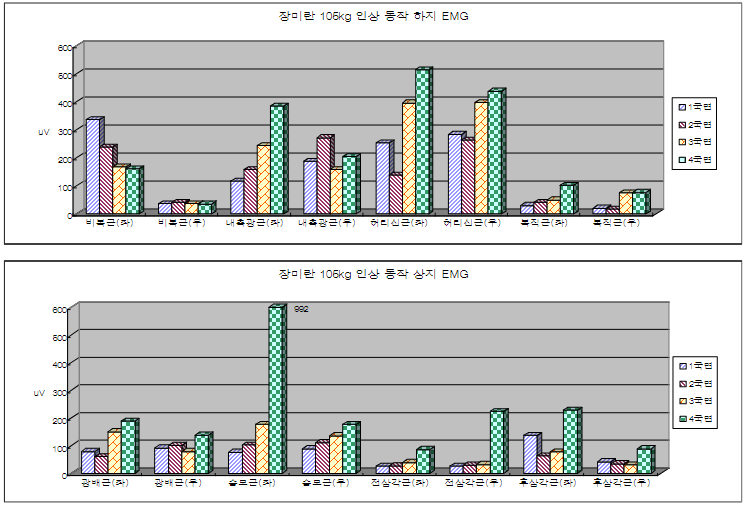

title: 그림 26. 장미란 선수의 인상동작 수행 시 근육활동에 대한 분석
context: 장미란 선수는 3,4국면에서 좌측 하지근을 우측보다 더 많이 활용합니다. 측정 결과 양쪽 무릎 신전근의 힘은 비슷하므로, 이는 근력 약화 문제가 아닌 그녀만의 동작 특성(오른발을 빠르고 짧게 누름)에서 기인합니다. 개선을 위해 오른발의 풀 동작 시 길고 강하게 수행하는 훈련이 필요하며, 3국면에서는 복직근과 광배근을 더 활용하는 동작으로 변화가 요구됩니다. 또한 3,4국면에서 오른발이 후방으로 빠지는 동작으로 인한 좌측 승모근 상해 위험에 주의해야 합니다.


--------------------------------


detail: 장미란 선수의 좌측 하지근 활용이 우측보다 더 많으며, 양쪽 무릎 신전근의 힘은 비슷하다. 오른발의 동작 특성으로 인해 근력 약화 문제가 아님. 3국면에서 복직근과 광배근의 활용 증가가 요구되며, 3,4국면에서 오른발의 후방 동작으로 인한 좌측 승모근 상해 위험에 주의해야 함.
entity: ['장미란 선수', '좌측 하지근', '우측 하지근', '무릎 신전근', '복직근', '광배근', '승모근']
hypotheticalQuestions: ['장미란 선수의 동작 특성을 개선하기 위한 훈련 방법은 무엇인가?', '오른발의 풀 동작을 길고 강하게 수행하기 위해 어떤 훈련이 필요할까?', '좌측 승모근 상해 위험을 줄이기 위한 예방 조치는 무엇일까?', '3국면에서 복직근과 광배근의 활용을 증가시키기 위한 전략은 무엇인가?']


--------------------------------


input: 1282,  0.01923$, 28원
output: 273,  0.01638$, 24원


AIMessage(content='```json\n{\n  "detail": "장미란 선수의 좌측 하지근 활용이 우측보다 더 많으며, 양쪽 무릎 신전근의 힘은 비슷하다. 오른발의 동작 특성으로 인해 근력 약화 문제가 아님. 3국면에서 복직근과 광배근의 활용 증가가 요구되며, 3,4국면에서 오른발의 후방 동작으로 인한 좌측 승모근 상해 위험에 주의해야 함.",\n  "entity": [\n    "장미란 선수",\n    "좌측 하지근",\n    "우측 하지근",\n    "무릎 신전근",\n    "복직근",\n    "광배근",\n    "승모근"\n  ],\n  "hypotheticalQuestions": [\n    "장미란 선수의 동작 특성을 개선하기 위한 훈련 방법은 무엇인가?",\n    "오른발의 풀 동작을 길고 강하게 수행하기 위해 어떤 훈련이 필요할까?",\n    "좌측 승모근 상해 위험을 줄이기 위한 예방 조치는 무엇일까?",\n    "3국면에서 복직근과 광배근의 활용을 증가시키기 위한 전략은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 273, 'prompt_tokens': 1282, 'total_tokens': 1555, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logp

In [27]:
draw_image_result(high_1_chart_path, chart_gpt4o_mini_chain, summary_high_1, high_1_title, parser)

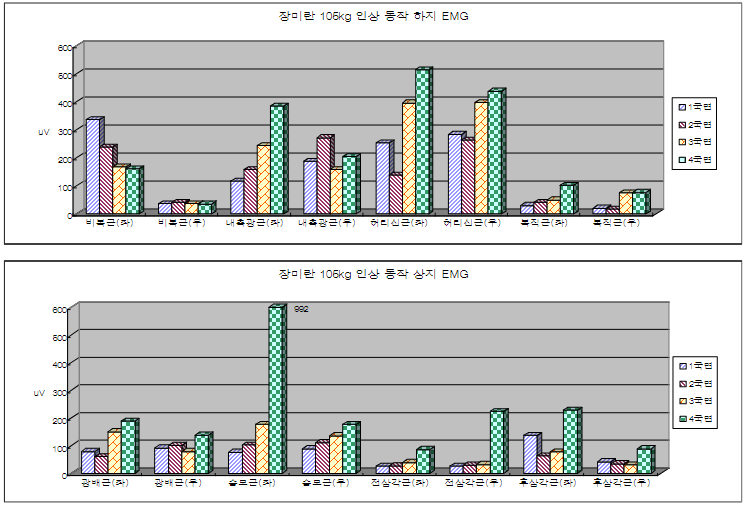

title: 그림 26. 장미란 선수의 인상동작 수행 시 근육활동에 대한 분석
context: 장미란 선수는 3,4국면에서 좌측 하지근을 우측보다 더 많이 활용합니다. 측정 결과 양쪽 무릎 신전근의 힘은 비슷하므로, 이는 근력 약화 문제가 아닌 그녀만의 동작 특성(오른발을 빠르고 짧게 누름)에서 기인합니다. 개선을 위해 오른발의 풀 동작 시 길고 강하게 수행하는 훈련이 필요하며, 3국면에서는 복직근과 광배근을 더 활용하는 동작으로 변화가 요구됩니다. 또한 3,4국면에서 오른발이 후방으로 빠지는 동작으로 인한 좌측 승모근 상해 위험에 주의해야 합니다.


--------------------------------


detail: 장미란 선수의 좌측 하지근 활용이 우측보다 더 많으며, 양쪽 무릎 신전근의 힘은 비슷하다. 오른발의 동작 특성으로 인해 근력 약화 문제가 아님. 3국면에서 복직근과 광배근의 활용 증가가 요구되며, 3,4국면에서 오른발의 후방 동작으로 인한 좌측 승모근 상해 위험에 주의해야 함.
entity: ['장미란 선수', '좌측 하지근', '우측 하지근', '무릎 신전근', '복직근', '광배근', '승모근']
hypotheticalQuestions: ['장미란 선수의 동작 특성을 개선하기 위한 훈련 방법은 무엇인가?', '오른발의 풀 동작을 길고 강하게 수행하기 위해 어떤 훈련이 필요할까?', '좌측 승모근 상해 위험을 줄이기 위한 예방 조치는 무엇일까?', '3국면에서 복직근과 광배근의 활용을 증가시키기 위한 전략은 무엇인가?']


--------------------------------


input: 1282,  0.01923$, 28원
output: 273,  0.01638$, 24원


AIMessage(content='```json\n{\n  "detail": "장미란 선수의 좌측 하지근 활용이 우측보다 더 많으며, 양쪽 무릎 신전근의 힘은 비슷하다. 오른발의 동작 특성으로 인해 근력 약화 문제가 아님. 3국면에서 복직근과 광배근의 활용 증가가 요구되며, 3,4국면에서 오른발의 후방 동작으로 인한 좌측 승모근 상해 위험에 주의해야 함.",\n  "entity": [\n    "장미란 선수",\n    "좌측 하지근",\n    "우측 하지근",\n    "무릎 신전근",\n    "복직근",\n    "광배근",\n    "승모근"\n  ],\n  "hypotheticalQuestions": [\n    "장미란 선수의 동작 특성을 개선하기 위한 훈련 방법은 무엇인가?",\n    "오른발의 풀 동작을 길고 강하게 수행하기 위해 어떤 훈련이 필요할까?",\n    "좌측 승모근 상해 위험을 줄이기 위한 예방 조치는 무엇일까?",\n    "3국면에서 복직근과 광배근의 활용을 증가시키기 위한 전략은 무엇인가?"\n  ]\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 273, 'prompt_tokens': 1282, 'total_tokens': 1555, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'l

In [28]:
draw_image_result(high_1_chart_path, chart_gpt4o_chain, summary_high_1, high_1_title, parser)